# 1. Import Libraries

In [2]:
from google.colab import drive
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, reciprocal
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# 2. Load Data

In [3]:

drive.mount('/content/drive')


unmon_features= pd.read_csv('/content/drive/MyDrive/MLproject/unmon_features.csv')
mon_features= pd.read_csv('/content/drive/MyDrive/MLproject/mon_features.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/MLproject/mon_labels.csv')

mon_features['label'] = mon_labels.values
unmon_features['label'] = -1

combined_data = pd.concat([mon_features, unmon_features], axis=0)
combined_data.fillna(0, inplace=True)


X = combined_data.drop('label', axis=1)
y = combined_data['label']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print("Combined Data Shape:", combined_data.shape)
print("Feature Matrix Shape (X):", X.shape)
print(X.head)
print("Target Vector Shape (y):", y.shape)

Combined Data Shape: (29000, 20)
Feature Matrix Shape (X): (29000, 19)
<bound method NDFrame.head of       total_num  total_sum_dir  total_avg  inpkt_num  inpkt_avg  inpkt_sum  \
0          1421        -603648   4.315749       1300   4.292023    5579.63   
1           518        -183296   4.611815        438   4.673242    2046.88   
2          1358        -574464   5.488969       1240   5.459452    6769.72   
3          1446        -615424   5.995512       1324   5.948693    7876.07   
4          1406        -602112   4.698869       1291   4.663873    6021.06   
...         ...            ...        ...        ...        ...        ...   
9995       4593       -1928704  12.494690       4180  12.360713   51667.78   
9996       5110       -2158592  13.844609       4663  13.729719   64021.68   
9997        361        -124416   3.568144        302   3.251291     981.89   
9998        509        -162304   6.892377        413   6.689346    2762.70   
9999       9990       -4785152   7.916714

# 3. Preprocess Data

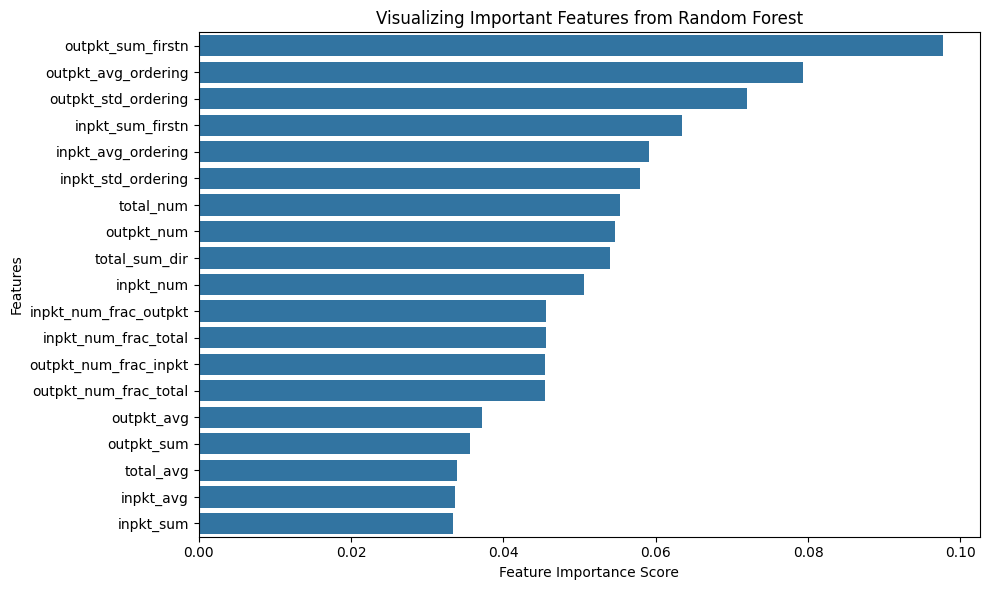

Selected Features: ['outpkt_sum_firstn', 'outpkt_avg_ordering', 'outpkt_std_ordering', 'inpkt_sum_firstn', 'inpkt_avg_ordering', 'inpkt_std_ordering', 'total_num', 'outpkt_num', 'total_sum_dir', 'inpkt_num']


In [5]:
# 랜덤 포레스트 모델로 특성 중요도 계산
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
feature_importances = rf_model.feature_importances_

# 특성 중요도 시각화
feature_imp = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features from Random Forest")
plt.tight_layout()
plt.show()

# 중요도 기준 상위 특성 선택
threshold = 0.05  # 중요도 기준 (조정 가능)
important_features = feature_imp[feature_imp >= threshold].index
print(f"Selected Features: {list(important_features)}")

# 중요 특성으로 데이터셋 구성
X_selected = X[important_features]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


(23200, 10) (5800, 10)


# 4. Build and Train the SVM Model

In [7]:
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state= 42)
svm_model.fit(X_train_scaled, y_train)


y_pred = svm_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.22913793103448277

Confusion Matrix:
 [[141   1  83 ...   6  16  23]
 [  1   4   0 ...   0   0   3]
 [  0   0  20 ...   0   0   0]
 ...
 [  0   0   0 ...   9   0   5]
 [  0   0   0 ...   0  38   0]
 [  0   0   0 ...   0   0  20]]


# 5. Hyperparameter Tuning

In [19]:
param_grid = {'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2)
grid.fit(X_train_scaled, y_train)

print(f"Grid Search 최적 파라미터: {grid.best_params_}")
print(f"Grid Search 최적 모델: {grid.best_estimator_}")


best_model = grid.best_estimator_
best_model.fit(X_train_scaled, y_train)



Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  40.4s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  39.5s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  40.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  41.6s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  43.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  40.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  43.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  42.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  38.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  40.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  41.4s
[CV] END .......................C=0.1, gamma=0.1

SVC(C=10, gamma=1)

# 6. Evaluate the Tuned Model

In [20]:
best_pred = best_model.predict(X_test_scaled)

precision = precision_score(y_test, best_pred, average='macro')
recall = recall_score(y_test, best_pred, average='macro')
accuracy_best = accuracy_score(y_test, best_pred)
conf_matrix_best = confusion_matrix(y_test, best_pred)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_pred , pos_label =1)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_values, recall_values, _ = precision_recall_curve(y_test, best_pred,pos_label =1)
pr_auc = auc(recall_values, precision_values)

print(f"Accuracy (Tuned Model): {accuracy_best:.4f}")
print(f"Confusion Matrix (Tuned Model):\n{conf_matrix_best}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

Accuracy (Tuned Model): 0.6343
Confusion Matrix (Tuned Model):
[[1641    2    9 ...    1    1    7]
 [   9   13    0 ...    0    0    2]
 [  14    0   14 ...    0    0    0]
 ...
 [  14    0    0 ...   14    0    1]
 [   5    1    0 ...    0   38    0]
 [   5    1    0 ...    0    0   18]]
Precision: 0.6121
Recall: 0.5370
ROC AUC: 0.4096
Precision-Recall AUC: 0.0050


# 7. Visualize Results

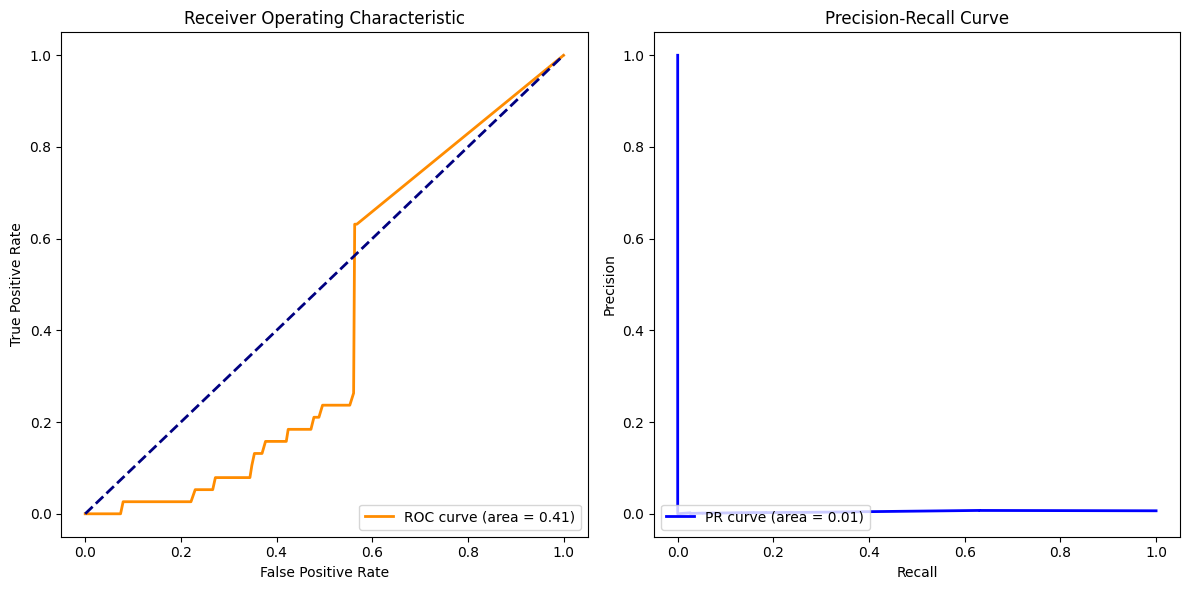

In [21]:
# 그래프 출력
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()